# Usage Demo : 


In [1]:
#import midi
import json
import glob
import numpy as np
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval import core, utils
from pprint import pprint
from sklearn.model_selection import LeaveOneOut
import random

## Absolute measurement: statistic analysis
### Assign dataset path

In [12]:
num_samples = 256
set1 = glob.glob('/home/src/music-guided-diffusion-main/datasets/maestro_chunks_10s/*')
print(len(set1))
set1 = random.sample(set1, num_samples)

set2 = glob.glob('/home/src/music-guided-diffusion-main/loggings/maestrox2_rep4_ps16/samples_cls_0/*.midi')
print(len(set2))
set2 = random.sample(set2, num_samples)

70611
256


construct empty dictionary to fill in measurement across samples

In [13]:
set1_eval = {'total_pitch_class_histogram':np.zeros((num_samples,12)), 
             'pitch_range':np.zeros((num_samples, 1)), 
            'mean_note_velocity':np.zeros((num_samples, 1)),
            'mean_note_duration':np.zeros((num_samples, 1)),
            'note_density':np.zeros((num_samples, 1))}

metrics_list = list(set1_eval.keys())

for i in range(0, num_samples):
    #print(set1[i])
    feature = core.extract_feature(set1[i])
    for j in range(len(metrics_list)):
        set1_eval[metrics_list[j]][i] = getattr(core.metrics(), metrics_list[j])(feature)

repeat for second dataset

In [14]:
set2_eval = {'total_pitch_class_histogram':np.zeros((num_samples,12)),
            'pitch_range':np.zeros((num_samples, 1)),
            'mean_note_velocity':np.zeros((num_samples, 1)),
            'mean_note_duration':np.zeros((num_samples, 1)),
            'note_density':np.zeros((num_samples, 1))}

for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    #print(set2[i])
    for j in range(len(metrics_list)):
        set2_eval[metrics_list[j]][i] = getattr(core.metrics(), metrics_list[j])(feature)

statistic analysis: absolute measurement

In [15]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' train_set')
    print('  mean: ', np.mean(set1_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set1_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' sample_set')
    print('  mean: ', np.mean(set2_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set2_eval[metrics_list[i]], axis=0))


total_pitch_class_histogram:
------------------------
 train_set
  mean:  [0.08811819 0.07357082 0.09145808 0.08675856 0.08595234 0.07258643
 0.07542462 0.08940713 0.0913404  0.08364841 0.07084365 0.07526637]
  std:  [0.09580126 0.07612755 0.10905782 0.0996628  0.08916563 0.07639846
 0.0884942  0.09963894 0.09615904 0.0984997  0.07346398 0.0827412 ]
------------------------
 sample_set
  mean:  [0.09605035 0.08559586 0.08170025 0.07915694 0.07360785 0.07621047
 0.08561301 0.08502989 0.08210584 0.08567313 0.0782504  0.09100601]
  std:  [0.12366605 0.08986392 0.08567788 0.08088499 0.07219501 0.07902821
 0.07854672 0.08608898 0.09128471 0.0871986  0.07819265 0.09233063]
pitch_range:
------------------------
 train_set
  mean:  [45.42578125]
  std:  [14.33044588]
------------------------
 sample_set
  mean:  [44.828125]
  std:  [12.21110495]
mean_note_velocity:
------------------------
 train_set
  mean:  [60.40817972]
  std:  [14.27265188]
------------------------
 sample_set
  mean:  [52

## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [23]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples-1))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        set1_intra[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0]][i] = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])


exhaustive cross-validation for inter-set distances measurement

In [17]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])

visualization of intra-set and inter-set distances

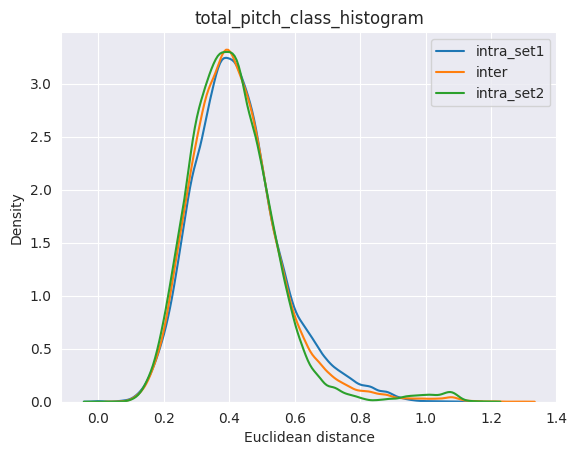

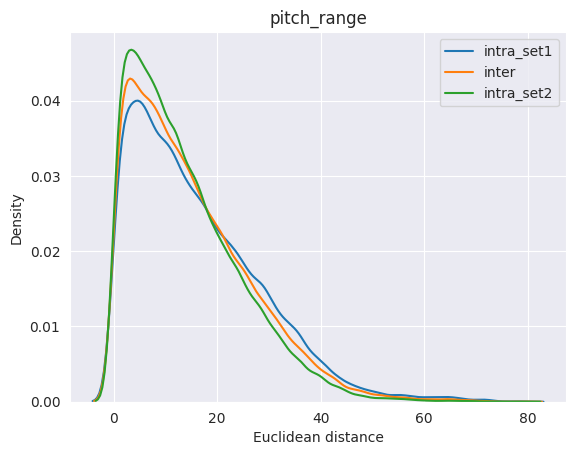

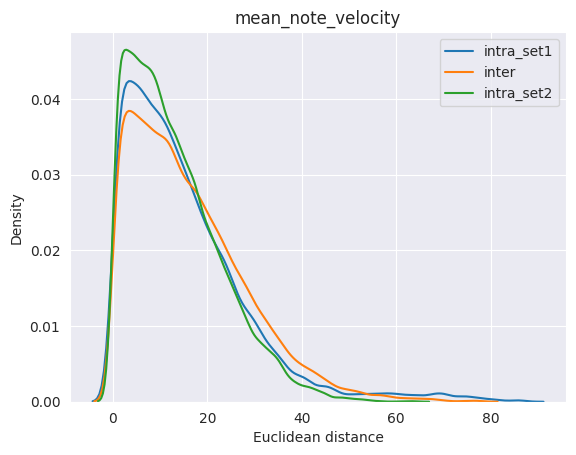

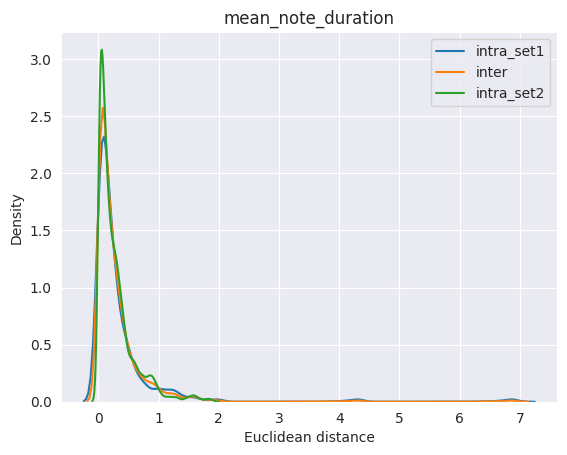

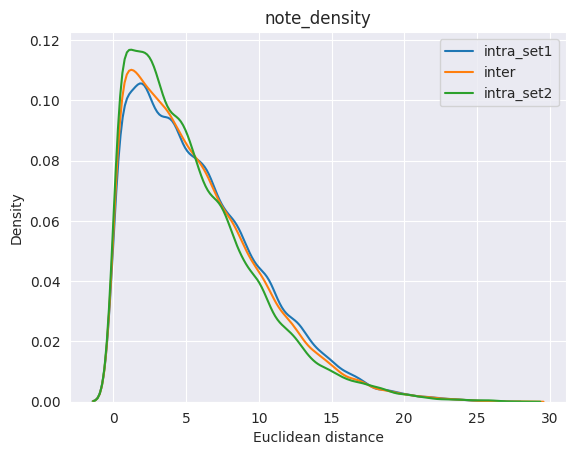

In [18]:
plot_set1_intra = np.transpose(set1_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_set2_intra = np.transpose(set2_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)

for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_set1_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_set2_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.legend()
    plt.savefig("test1.png")
    plt.show()
    

the difference of intra-set and inter-set distances.

In [ ]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' train_set1')
    print('  Kullback–Leibler divergence:', utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i]))
    
    print(' sample_set2')
    print('  Kullback–Leibler divergence:', utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i]))
